In [30]:
import pandas as pd
import numpy as np
import itertools
from sklearn.isotonic import IsotonicRegression
import statsmodels.api as sm

In [2]:
strokes_gained_putts = {'Uphill':[],'Downhill':[]}
for year in range(2003,2010):
    data = pd.read_csv('data/%d.csv'%(year,))
    uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))
    data = data[['Course_#','Round','Hole','Player_#','Hole_Score','Shot','From_Location(Scorer)','To_Location(Laser)','Shots_taken_from_location',
            'Distance_from_hole','Started_at_X','Started_at_Y','Went_to_X','Went_to_Y','Started_at_Z','Went_to_Z']].values

    for crhtup in uCRHtps:
        subset = data[np.where((data[:,0]==crhtup[0]) & (data[:,1]==crhtup[1]) & (data[:,2]==crhtup[2]))]
        if subset.shape[0]<50:
            continue
        players = pd.unique(subset[:,3])
        scores = {player:int(subset[np.where(subset[:,3]==player)][0,4]) for player in players}
        ave_score = np.mean(np.array([scores.get(player) for player in players]))

        for player in players:
            sub = subset[np.where(subset[:,3]!=player)]
            model = IsotonicRegression(out_of_bounds='clip')
            model.fit(sub[np.where(sub[:,6]=='Green')][:,9],sub[np.where(sub[:,6]=='Green')][:,8])

            #tot_strokes_gained = ave_score - scores[player]

            #model_predicted_strokes_gained = 0

            sub = subset[np.where(subset[:,3]==player)]

            for shot in range(min(sub[:,5]),sub[0,4]+1):
                if shot==sub[0,4]:
                    if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                        continue
                    if sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14] > 0:
                        strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                               model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
                    else:
                        strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                                 model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
                else:
                    if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                        continue
                    if sub[np.where(sub[:,5]==shot)][0,14] - sub[np.where(sub[:,5]==shot)][0,13] > 0:
                        strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                               model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] -
                                                               model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))
                    else:
                        strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                                 model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 
                                                                 model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))


/Users/adamlevin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [103]:
data = pd.read_csv('data/2008.csv')

In [104]:
uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))

data = data[['Course_#','Round','Hole','Player_#','Hole_Score','Shot','From_Location(Scorer)','To_Location(Laser)','Shots_taken_from_location',
            'Distance_from_hole','Started_at_X','Started_at_Y','Went_to_X','Went_to_Y','Started_at_Z','Went_to_Z']].values

In [105]:
# def convert_cats(cat):
#     if cat in ['Green Side Bunker','Fairway Bunker']:
#         return 'Bunker'
#     elif cat not in ['Green','Fairway','Fringe','Primary Rough','Intermediate Rough','Tee Box']:
#         return 'Other'
#     else:
#         return cat

# if 'Cat' in data.columns:
#     data = data.drop('Cat',axis=1)
# data.insert(len(data.columns),'Cat',[convert_cats(c) for c in data['From_Location(Scorer)'].tolist()])

In [66]:
#errors = []
#strokes_gained_per_cat = {'Bunker':[],'Other':[],'Green':[],'Fairway':[],'Fringe':[],'Primary Rough':[],
#                             'Intermediate Rough':[], 'Tee Box':[]}
strokes_gained_putts = {'Uphill':[],'Downhill':[]}

for crhtup in uCRHtps:
    subset = data[np.where((data[:,0]==crhtup[0]) & (data[:,1]==crhtup[1]) & (data[:,2]==crhtup[2]))]
    if subset.shape[0]<50:
        continue
    players = pd.unique(subset[:,3])
    scores = {player:int(subset[np.where(subset[:,3]==player)][0,4]) for player in players}
    ave_score = np.mean(np.array([scores.get(player) for player in players]))

    for player in players:
        sub = subset[np.where(subset[:,3]!=player)]
        model = IsotonicRegression(out_of_bounds='clip')
        model.fit(sub[np.where(sub[:,6]=='Green')][:,9],sub[np.where(sub[:,6]=='Green')][:,8])

        #tot_strokes_gained = ave_score - scores[player]

        #model_predicted_strokes_gained = 0

        sub = subset[np.where(subset[:,3]==player)]

        for shot in range(min(sub[:,5]),sub[0,4]+1):
            if shot==sub[0,4]:
                if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                    continue
                if sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14] > 0:
                    strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                           sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                           model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
                else:
                    strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                             sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                             model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
            else:
                if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                    continue
                if sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14] > 0:
                    strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                           sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                           model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] -
                                                           model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))
                else:
                    strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                             sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                             model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 
                                                             model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))
                        
    #errors.append((model_predicted_strokes_gained - tot_strokes_gained))


#print pd.Series(errors).describe()
# for cat in strokes_gained_per_cat:
#     print cat, pd.Series(strokes_gained_per_cat[cat]).describe()
for slope in strokes_gained_putts:
    print slope, pd.Series(strokes_gained_putts[slope]).describe()

Uphill count                                                216444
unique                                               216434
top       (2.39198802781, 0.00699999999995, -1.110223024...
freq                                                      3
dtype: object
Downhill count                                      185389
unique                                     185380
top       (14.1458661558, -0.116, 0.777777777778)
freq                                            2
dtype: object


In [105]:
strokes_gained_putts['Uphill'].sort()
strokes_gained_putts['Downhill'].sort()
x1 = np.array([i[1] for i in strokes_gained_putts['Uphill'] if i[0]<14 and i[0]>4])
y1 = np.array([i[2] for i in strokes_gained_putts['Uphill'] if i[0]<14 and i[0]>4])
x2 = np.array([i[1] for i in strokes_gained_putts['Downhill'] if i[0]<14 and i[0]>4])
y2 = np.array([i[2] for i in strokes_gained_putts['Downhill'] if i[0]<14 and i[0]>4])

bins = np.linspace(np.percentile(x1,1), np.percentile(x1,99), 15)
b1 = np.digitize(x1, bins)
x1ms = [x1[b1 == i].mean() for i in range(1, len(bins))]
y1ms = [y1[b1 == i].mean() for i in range(1, len(bins))]
bins = np.linspace(np.percentile(x2,1), np.percentile(x2,99), 15)
b2 = np.digitize(x2, bins)
x2ms = [x2[b2 == i].mean() for i in range(1, len(bins))]
y2ms = [y2[b2 == i].mean() for i in range(1, len(bins))]

In [106]:
pd.Series(x1).describe()

count    59473.000000
mean         0.116831
std          0.092089
min          0.001000
25%          0.048000
50%          0.096000
75%          0.163000
max          1.899000
dtype: float64

In [107]:
print [len(x2[b2==i]) for i in range(1,len(bins))]

[304, 449, 591, 902, 1181, 1596, 2236, 3058, 3744, 5071, 6624, 7992, 9604, 9712]


In [9]:
def confidence_interval_difference_of_two_means(sample_1,sample_2,its,p):
    mean_diffs = []
    for _ in xrange(its):
        mean_1 = np.mean(np.random.choice(sample_1,len(sample_1)))
        mean_2 = np.mean(np.random.choice(sample_2,len(sample_2)))
        mean_diffs.append(mean_1 - mean_2)
    return np.percentile(mean_diffs,[(100.0-p)/2,(p+100.0)/2])

In [10]:
def hypo_test_difference_of_two_means_one_sided(sample_b,sample_s,its):
    test_stat = np.mean(sample_b) - np.mean(sample_s)
    haps = 0
    for _ in xrange(its):
        pooled_sample = np.append(sample_b,sample_s)
        np.random.shuffle(pooled_sample)
        if np.mean(pooled_sample[:len(sample_b)]) - np.mean(pooled_sample[len(sample_b):]) >= test_stat:
            haps += 1
    return haps/float(its)

In [112]:
def confidence_interval_mean(sample,its,p):
    means = []
    for _ in xrange(its):
        mean = np.mean(np.random.choice(sample,len(sample)))
        means.append(mean)
    return np.percentile(means,[(100.0-p)/2,(p+100.0)/2])

In [11]:
def cohens_d(sample_1,sample_2):
    n1 = len(sample_1)
    n2 = len(sample_2)
    v1 = np.var(sample_1,ddof=1)
    v2 = np.var(sample_2,ddof=1)
    pooled_var = (((n1-1)*v1 + (n2-2)*v2) / (n1 + n2 -2)) ** .5
    return (np.mean(sample_1) - np.mean(sample_2)) / pooled_var

In [12]:
for i in range(len(bins)):
    print x1ms[i]
    print y1ms[i], y2ms[i], y1ms[i] - y2ms[i]
    print cohens_d(y1[b1 == i+1],y2[b2 == i+1])
    if y1ms[i]>y2ms[i]:
        p = hypo_test_difference_of_two_means_one_sided(y1[b1 == i+1],y2[b2 == i+1],5000)
        if p < .01:
            print p,'***'
        elif p < .05:
            print p,'**'
        elif p < .1:
            print p,'*'
    else:
        p = hypo_test_difference_of_two_means_one_sided(y2[b2 == i+1],y1[b1 == i+1],5000)
        if p < .01:
            print p,'***'
        elif p < .05:
            print p,'**'
        elif p < .1:
            print p,'*'
    print confidence_interval_difference_of_two_means(y1[b1 == i+1],y2[b2 == i+1],5000,99)

1.31647855324
-0.00112564142566 -0.00154154610592 0.000415904680257
0.00891210211676
0.0 ***
[ 0.00013677  0.00068498]
3.05460752859
-0.00406485086566 -0.0275324594206 0.0234676085549
0.105444314392
0.0 ***
[ 0.02186903  0.02496396]
5.24696929191
0.0101850304803 -0.0586122525444 0.0687972830247
0.151553123119
0.0 ***
[ 0.06433824  0.07320223]
7.4480288498
0.00988199145538 -0.034148425628 0.0440304170834
0.0846088231218
0.0 ***
[ 0.03791903  0.05013827]
9.6137234011
0.00398179362613 -0.0140255666375 0.0180073602636
0.0347687414537
0.0 ***
[ 0.01113967  0.0248569 ]
11.752214021
-0.00352372980507 -0.00197556016426 -0.0015481696408
-0.00314083125364
[-0.00843533  0.00542123]
13.8987651038
-0.00510520373491 0.0109428372357 -0.0160480409706
-0.0344871996044
0.0 ***
[-0.0231755  -0.00855235]
16.0458731923
-0.00261380073818 0.0141055360745 -0.0167193368127
-0.0383191465225
0.0 ***
[-0.02392142 -0.00972443]
18.1896402497
0.000111779809826 0.0137197509362 -0.0136079711264
-0.0330777203398
0.0 **

IndexError: list index out of range

In [100]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

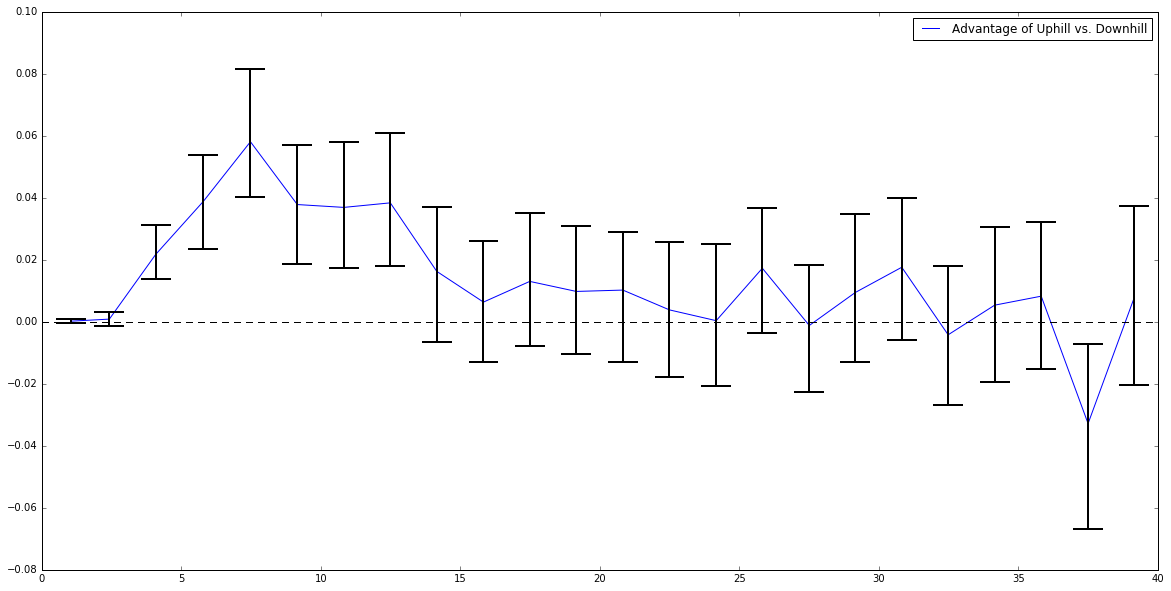

In [95]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot((np.array(x1ms)+np.array(x2ms))/2,np.array(y1ms)-np.array(y2ms),label='Advantage of Uphill vs. Downhill')
x = [0,0]
for i in range(len(bins)-1):
    ci = confidence_interval_difference_of_two_means(y1[b1 == i+1],y2[b2 == i+1],500,99)
    plt.plot([(x1ms[i] + x2ms[i])/2, (x1ms[i] + x2ms[i])/2], [ci[0], ci[1]], 'k-', lw=2)
    plt.plot([(x1ms[i] + x2ms[i])/2 - .5,(x1ms[i] + x2ms[i])/2 + .5],[ci[0],ci[0]],'k-', lw=2)
    plt.plot([(x1ms[i] + x2ms[i])/2 - .5,(x1ms[i] + x2ms[i])/2 + .5],[ci[1],ci[1]],'k-', lw=2)
    plt.plot([0,100],[0,0],'k--',lw=1)


plt.legend()
fig.savefig('Uphill vs Downhill.png')

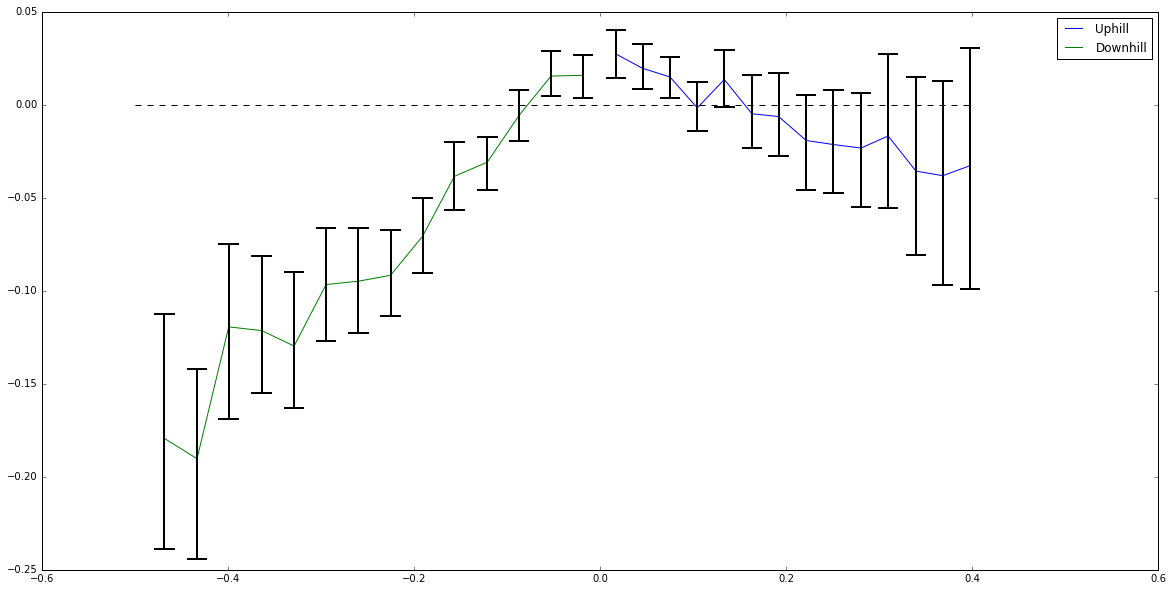

In [114]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot(x1ms,y1ms,label='Uphill')
plt.plot(x2ms,y2ms,label='Downhill')
plt.plot([-.5,.4],[0,0],'k--',lw=1)
for i in range(len(bins)-1):
    ci1 = confidence_interval_mean(y1[b1 == i+1],500,99)
    ci2 = confidence_interval_mean(y2[b2 == i+1],500,99)
    plt.plot([x1ms[i],x1ms[i]], [ci1[0], ci1[1]], 'k-', lw=2)
    plt.plot([x2ms[i],x2ms[i]], [ci2[0], ci2[1]], 'k-', lw=2)
    plt.plot([x1ms[i] - .01,x1ms[i] + .01],[ci1[0],ci1[0]],'k-', lw=2)
    plt.plot([x1ms[i] - .01,x1ms[i] + .01],[ci1[1],ci1[1]],'k-', lw=2)
    plt.plot([x2ms[i] - .01,x2ms[i] + .01],[ci2[0],ci2[0]],'k-', lw=2)
    plt.plot([x2ms[i] - .01,x2ms[i] + .01],[ci2[1],ci2[1]],'k-', lw=2)
plt.legend()

In [25]:
from scipy.stats import probplot
import scipy.stats

((array([-1.43017034, -1.36241765, -1.32553687, ...,  1.35592799,
          1.39280877,  1.46056145]),
  array([-1.625     , -1.61007463, -1.375     , ...,  1.70833333,
          1.75      ,  1.97740113])),
 (0.94315565560002335, 0.00086378158004732711, 0.94310378716969379))

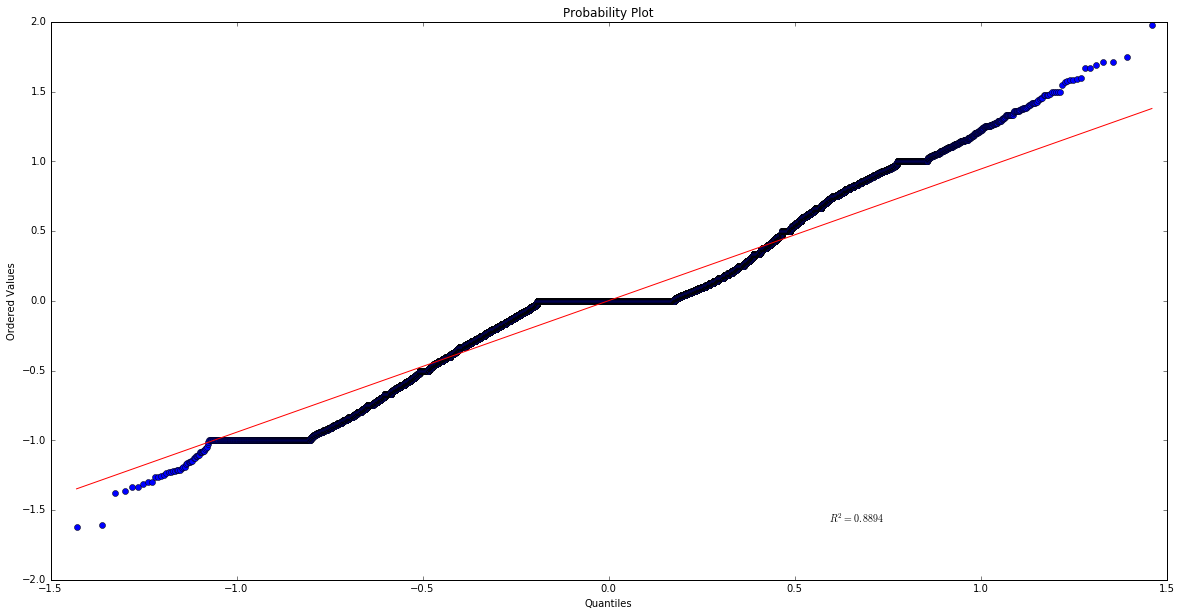

In [20]:
fig,ax = plt.subplots(figsize=(20, 10))
probplot(strokes_gained_per_cat['Green'],(np.mean(strokes_gained_per_cat['Green']), np.std(strokes_gained_per_cat['Green'])),plot=plt)

In [26]:
rv = scipy.stats.laplace(loc=np.mean(strokes_gained_per_cat['Green']), scale=(np.var(strokes_gained_per_cat['Green'])/2)**.5)

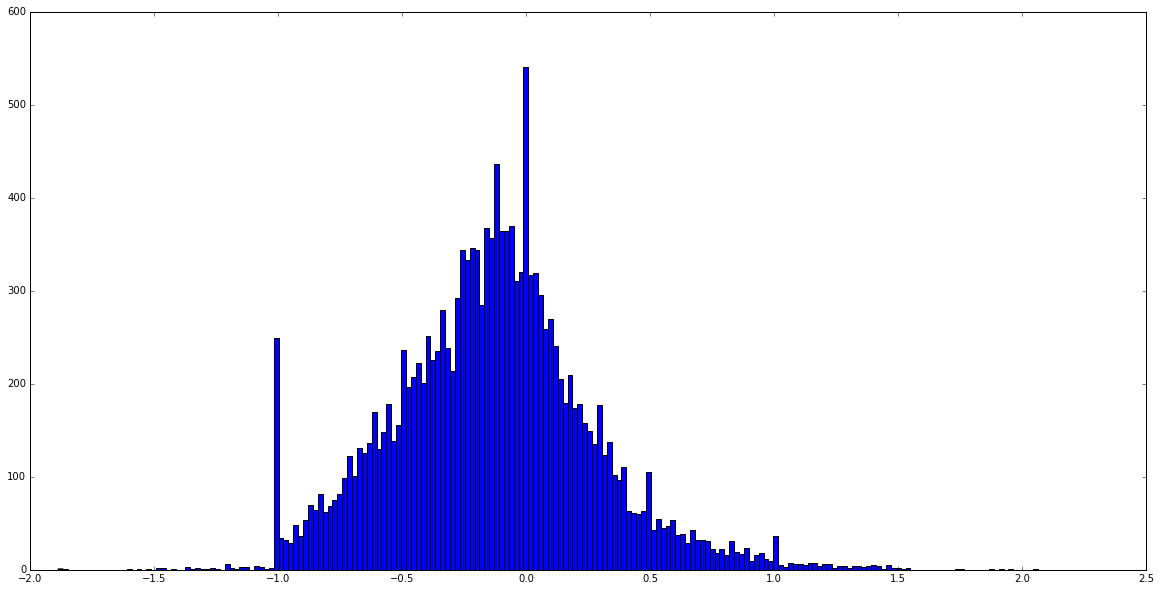

In [39]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.hist(strokes_gained_per_cat['Primary Rough'],bins=200)
x = np.linspace(min(strokes_gained_per_cat['Primary Rough']),max(strokes_gained_per_cat['Primary Rough']),len(strokes_gained_per_cat['Primary Rough']))
#plt.plot(x,10000*rv.pdf(x))

In [42]:
def hypo_test_above_below_zero(sample,its):
    above_0,below_0 = 0,0
    for _ in xrange(its):
        samp = np.random.choice(sample,len(sample))
        if np.mean(samp)>0:
            above_0 +=1
        else:
            below_0 +=1
    return above_0/float(its) - below_0/float(its)

In [49]:
hypo_test_above_below_zero(strokes_gained_per_cat['Bunker'],10000)

-1.0

In [68]:
hypo_test_difference_of_two_means_one_sided(strokes_gained_putts['Uphill'],strokes_gained_putts['Downhill'],10000)

0.0

## Make baseline models for each category

In [16]:
##load in some training data
inds_chosen = {}
for year in range(2003,2017):
    data = pd.read_csv('data/%d.csv' % (year,));
    data = data[data.Shot!=1]
    if year==2003:
        df = data.loc[0:2,:]
    inds_chosen[year] = np.random.choice(range(len(data)),size=100000,replace=False)
    df = df.append(data.iloc[inds_chosen[year]])
del data

In [17]:
df.shape

(1400000, 41)

In [290]:
def convert_cats(cat,dist):
    if cat in ['Green Side Bunker','Fairway Bunker']:
        return 'Bunker'
    elif cat not in ['Green','Fairway','Fringe','Primary Rough','Intermediate Rough','Tee Box']:
        return 'Other'
    elif cat=='Fringe' and dist>120:
        return 'Intermediate Rough'
    elif cat=='Tee Box':
        return 'Fairway'
    else:
        return cat

In [19]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [20]:
df.Cat.value_counts()

Green                 780190
Fairway               318194
Primary Rough         148440
Bunker                 67815
Intermediate Rough     43801
Fringe                 32511
Other                   9048
Tee Box                    1
Name: Cat, dtype: int64

In [21]:
##fit models
overall_models = {}
for cat in pd.unique(df.Cat):
    overall_models[cat] = IsotonicRegression(out_of_bounds='clip')
    overall_models[cat].fit(df[df.Cat==cat].Distance_from_hole,df[df.Cat==cat].Shots_taken_from_location)

In [24]:
##let's see performance. load in some testing data
for year in range(2003,2017):
    data = pd.read_csv('data/%d.csv' % (year,));
    data = data[data.Shot!=1]
    if year==2003:
        df = data.loc[0:2,:]
    inds_to_choose_from = list(set(range(len(data))) - set(inds_chosen[year]))
    inds = np.random.choice(inds_to_choose_from,size=100000,replace=False)
    df = df.append(data.iloc[inds])
del data

In [25]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [26]:
df.Cat.value_counts()

Green                 779355
Fairway               319520
Primary Rough         148468
Bunker                 67384
Intermediate Rough     43678
Fringe                 32457
Other                   9138
Name: Cat, dtype: int64

In [28]:
##Calculate RMSE of prediction for each Category
for cat in pd.unique(df.Cat):
    predictions = overall_models[cat].predict(df[df.Cat==cat].Distance_from_hole)
    residuals = predictions - df[df.Cat==cat].Shots_taken_from_location
    RMSE = np.mean(residuals**2)**.5
    print '%s:%s%g' % (cat,' '*(30-len(cat)),RMSE)

Green: 0.341199
Primary Rough: 0.604008
Bunker: 0.614023
Intermediate Rough: 0.548045
Fairway: 0.563975
Fringe: 0.42991
Other: 0.71301


## Add in slope of putts

In [29]:
for year in range(2003,2017):
    data = pd.read_csv('data/%d.csv' % (year,));
    data = data[data.Shot!=1]
    if year==2003:
        df = data.loc[0:2,:]
    df = df.append(data.iloc[inds_chosen[year]])
del data

In [31]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [32]:
predictions = overall_models['Green'].predict(df[df.Cat=='Green'].Distance_from_hole)
residuals = predictions - df[df.Cat=='Green'].Shots_taken_from_location

In [33]:
X = np.column_stack([df[df.Cat=='Green'].Started_at_Z,
                     df[df.Cat=='Green'].Distance_from_hole*df[df.Cat=='Green'].Started_at_Z])
y = residuals

In [34]:
X = sm.add_constant(X)

In [35]:
model = sm.OLS(y,X)
results = model.fit()
print results.summary()

                                OLS Regression Results                               
Dep. Variable:     Shots_taken_from_location   R-squared:                       0.000
Model:                                   OLS   Adj. R-squared:                  0.000
Method:                        Least Squares   F-statistic:                     116.0
Date:                       Mon, 05 Sep 2016   Prob (F-statistic):           4.30e-51
Time:                               14:46:04   Log-Likelihood:            -2.6341e+05
No. Observations:                     780190   AIC:                         5.268e+05
Df Residuals:                         780187   BIC:                         5.269e+05
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------

In [36]:
##load more testing data to see improvement
for year in range(2003,2017):
    data = pd.read_csv('data/%d.csv' % (year,));
    data = data[data.Shot!=1]
    if year==2003:
        df = data.loc[0:2,:]
    inds_to_choose_from = list(set(range(len(data))) - set(inds_chosen[year]))
    inds = np.random.choice(inds_to_choose_from,size=100000,replace=False)
    df = df.append(data.iloc[inds])
del data

In [37]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [44]:
##Calculate RMSE of prediction for each Category
for cat in pd.unique(df.Cat):
    predictions = overall_models[cat].predict(df[df.Cat==cat].Distance_from_hole)
    if cat=='Green':
        X = np.column_stack([df[df.Cat==cat].Started_at_Z,
                             df[df.Cat==cat].Started_at_Z*df[df.Cat==cat].Distance_from_hole])
        X = sm.add_constant(X)
        predictions2 = results.predict(X)
        predictions += predictions2
    residuals = predictions - df[df.Cat==cat].Shots_taken_from_location
    RMSE = np.mean(residuals**2)**.5
    print '%s:%s%g' % (cat,' '*(30-len(cat)),RMSE)

Fairway:                       0.563751
Green:                         0.340242
Intermediate Rough:            0.547899
Primary Rough:                 0.604896
Fringe:                        0.428679
Bunker:                        0.613151
Other:                         0.712633
Tee Box:                       2


In [45]:
(.341199 - .340242)/.341199

0.0028048147855063636

Very modest improvement of .2%.

## Add in 'Green to work with' for non-putts

In [59]:
from math import atan2,radians

In [68]:
simple_coords = pd.DataFrame({'x':[3,2,5,6,10,-1,-1,-6,-8],
                              'y':[5,4,2,-10,20,-1,6,-6,7]})

In [69]:
simple_coords

,x,y
0,3,5
1,2,4
2,5,2
3,6,-10
4,10,20
5,-1,-1
6,-1,6
7,-6,-6
8,-8,7


In [70]:
simple_coords['distance'] = (simple_coords.x**2 + simple_coords.y**2)**.5
simple_coords['angle'] = [atan2(y,x) for x,y in zip(simple_coords.x,simple_coords.y)]

In [71]:
simple_coords

,x,y,distance,angle
0,3,5,5.830952,1.030377
1,2,4,4.472136,1.107149
2,5,2,5.385165,0.380506
3,6,-10,11.661904,-1.030377
4,10,20,22.360680,1.107149
5,-1,-1,1.414214,-2.356194
6,-1,6,6.082763,1.735945
7,-6,-6,8.485281,-2.356194
8,-8,7,10.630146,2.422763


In [72]:
slack = radians(30)

In [86]:
def get_green_to_work_with(point):
    angle = atan2(point[0],point[1])
    print angle
    sub = simple_coords[(simple_coords.angle>angle-slack) & (simple_coords.angle<angle+slack)]
    print sub
    return sub.distance.max()

In [88]:
get_green_to_work_with((-3,4))

-0.643501108793
   x   y   distance     angle
3  6 -10  11.661904 -1.030377


11.661903789690601

In [89]:
##Now need whole holes as opposed to random shots for training data
inds_chosen2 = {}
for year in range(2003,2017):
    cols = ['Course_#','Round','Hole','Permanent_Tournament_#']
    data = pd.read_csv('data/%d.csv' % (year,))
    if year==2003:
        df = data.loc[0:2,:]
    inds_chosen2[year] = np.random.choice(range(len(data.drop_duplicates(cols))),size=200,replace=False)
    samp = set([tuple(i) for i in data.drop_duplicates(cols).iloc[inds_chosen2[year]][cols].values.astype(int).tolist()])
    inds = [u for u,i in enumerate(data[cols].values.astype(int).tolist()) if tuple(i) in samp]
    df = df.append(data.iloc[inds])
    if year==2003:
        df = df.drop(data.iloc[0:2].index,axis=0)
df = df.reset_index()
del data
print len(df)

1026476


In [91]:
##Not modeling First shots on each whole since difficulty is given by average strokes
df = df[df.Shot!=1]
print len(df)

764263


In [94]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [222]:
def get_green_to_work_with(df,points,slack):
    df.insert(len(df.columns),'angle',[atan2(y,x) for x,y in zip(df.Started_at_X,
                                                                 df.Started_at_Y)])
    ww = []
    def get_sub(df,angle,slack):
        return df[(df.angle>angle-slack) & (df.angle<angle+slack)]
    for point in points:
        angle = atan2(point[1],point[0])
        sub = get_sub(df,angle,slack)
        c = 0
        while len(sub)==0:
            c += 1
            if c==15:
                break
            sub = get_sub(df,angle,slack+2)
        if c==15:
            ww.append(np.nan)
        else:
            ww.append(sub.Distance_from_hole.max())
    return ww

In [95]:
df.insert(len(df.columns),'Green_to_work_with',[0]*len(df))

In [223]:
for tup,df_ in df.groupby(['Course_#','Hole','Round']):
    green = df_[df_.Cat=='Green']
    if len(green)<5:
        continue
    non_green = df_[df_.Cat!='Green']
    df.loc[(df['Course_#']==tup[0]) 
           & (df['Hole']==tup[1]) 
           & (df['Round']==tup[2])
           & (df.Cat!='Green'), 'Green_to_work_with'] \
                = get_green_to_work_with(green,zip(non_green.Started_at_X,non_green.Started_at_Y),slack=radians(15))

In [134]:
df[df.Cat!='Green'].Green_to_work_with.dropna().values

array([ 51.22257859,  25.02694235,  47.78093417, ...,  26.83487683,
        44.94499237,  53.17613467])

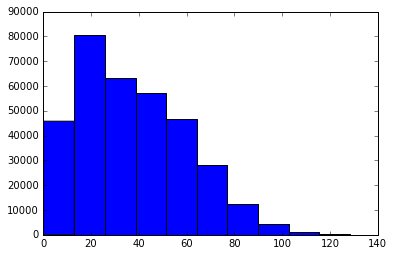

In [187]:
plt.hist(df[df.Cat!='Green'].Green_to_work_with.dropna().values);

In [110]:
df.insert(len(df.columns),'Difficulty_Baseline',[0]*len(df))
for cat in pd.unique(df.Cat):
    df.loc[df.Cat==cat,'Difficulty_Baseline'] = overall_models[cat].predict(df[df.Cat==cat].Distance_from_hole)

In [224]:
non_green = df[df.Cat!='Green']

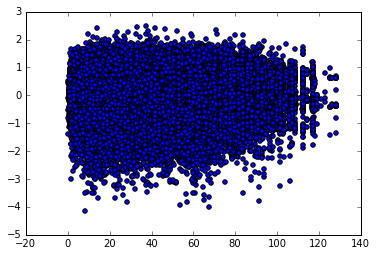

In [225]:
plt.scatter(non_green.Green_to_work_with,non_green.Difficulty_Baseline - non_green.Shots_taken_from_location);

In [226]:
gww = non_green.Green_to_work_with.fillna(non_green.Green_to_work_with.mean())
dist = non_green.Distance_from_hole.values
resid = (non_green.Difficulty_Baseline - non_green.Shots_taken_from_location)

In [227]:
np.corrcoef(gww,resid)

array([[ 1.        ,  0.01971726],
       [ 0.01971726,  1.        ]])

In [247]:
X = gww.values
X_c = pd.get_dummies(non_green.Cat).values
X_d = dist
X = sm.add_constant(X)
X = np.hstack([np.multiply(X_c[:,[0,1]+[3,5]],X[:,0][:,None]),
               np.multiply(X_c[:,[0,1]+[3,5]],X[:,1][:,None])])
y = resid

ValueError: operands could not be broadcast together with shapes (182,4) (339744,1) 

In [229]:
X.shape

(339744, 8)

In [230]:
pd.get_dummies(non_green.Cat).head()

,Bunker,Fairway,Fringe,Intermediate Rough,Other,Primary Rough,Tee Box
19046,0,1,0,0,0,0,0
19047,0,1,0,0,0,0,0
19049,0,1,0,0,0,0,0
19050,0,0,0,0,0,1,0
19051,0,1,0,0,0,0,0


In [231]:
model_2 = sm.OLS(y,X)
results_2 = model_2.fit()
print results_2.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.24
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           2.24e-44
Time:                        18:06:12   Log-Likelihood:            -2.9501e+05
No. Observations:              339744   AIC:                         5.900e+05
Df Residuals:                  339736   BIC:                         5.901e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0166      0.006     -2.999      0.0

In [232]:
##Let's see if this improves the RSME on some test data
for year in range(2003,2017):
    cols = ['Course_#','Round','Hole','Permanent_Tournament_#']
    data = pd.read_csv('data/%d.csv' % (year,))
    if year==2003:
        df = data.loc[0:2,:]
    inds_not_chosen = list(set(range(len(data.drop_duplicates(cols)))) - set(inds_chosen2[year]))
    test_inds = np.random.choice(inds_not_chosen,size=200,replace=False)
    samp = set([tuple(i) for i in data.drop_duplicates(cols).iloc[test_inds][cols].values.astype(int).tolist()])
    inds = [u for u,i in enumerate(data[cols].values.astype(int).tolist()) if tuple(i) in samp]
    df = df.append(data.iloc[inds])
    if year==2003:
        df = df.drop(data.iloc[0:2].index,axis=0)
df = df.reset_index()
del data
print len(df)

1014042


In [233]:
df = df[df.Shot!=1]
print len(df)
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

755318


In [234]:
df.insert(len(df.columns),'Difficulty_Baseline',[0]*len(df))
for cat in pd.unique(df.Cat):
    df.loc[df.Cat==cat,'Difficulty_Baseline'] = overall_models[cat].predict(df[df.Cat==cat].Distance_from_hole)

In [235]:
df.insert(len(df.columns),'Green_to_work_with',[0]*len(df))
for tup,df_ in df.groupby(['Course_#','Hole','Round']):
    green = df_[df_.Cat=='Green']
    if len(green)<5:
        continue
    non_green = df_[df_.Cat!='Green']
    df.loc[(df['Course_#']==tup[0]) 
           & (df['Hole']==tup[1]) 
           & (df['Round']==tup[2])
           & (df.Cat!='Green'), 'Green_to_work_with'] \
                = get_green_to_work_with(green,zip(non_green.Started_at_X,non_green.Started_at_Y),slack=radians(15))

In [236]:
df.insert(len(df.columns),'Green_to_work_with_pred',[0]*len(df))

In [240]:
X = df[df.Cat!='Green'].Green_to_work_with.values
X_c = pd.get_dummies(df[df.Cat!='Green'].Cat).values
X = sm.add_constant(X)
X = np.hstack([np.multiply(X_c[:,[0,1]+[3,5]],X[:,0][:,None]),
               np.multiply(X_c[:,[0,1]+[3,5]],X[:,1][:,None])])

In [241]:
X.shape

(335992, 8)

In [242]:
df.loc[df.Cat!='Green','Green_to_work_with_pred'] = results_2.predict(X)

In [249]:
for cat in pd.unique(df.Cat):
    RSME_baseline = np.mean((df[df.Cat==cat].Shots_taken_from_location - 
                             df[df.Cat==cat].Difficulty_Baseline)**2)**.5
    RSME_with_green_to_work_with = np.mean((df[df.Cat==cat].Shots_taken_from_location - 
         (df[df.Cat==cat].Difficulty_Baseline - df[df.Cat==cat].Green_to_work_with_pred))**2)**.5
    improvement = (RSME_baseline - RSME_with_green_to_work_with)/RSME_baseline
    print cat, RSME_baseline, RSME_with_green_to_work_with,improvement

Green 0.33909417746 0.33909417746 0.0
Fairway 0.565610522012 0.56554590816 0.00011423735913
Bunker 0.617027435654 0.616731120395 0.000480230280639
Intermediate Rough 0.551504682338 0.551263021284 0.000438184954875
Primary Rough 0.605120383953 0.6045461719 0.000948922013668
Other 0.693807261119 0.693807261119 0.0
Fringe 0.427927160295 0.427927160295 0.0


Very modest improvements.

## Change in Z coordinate for non-putts

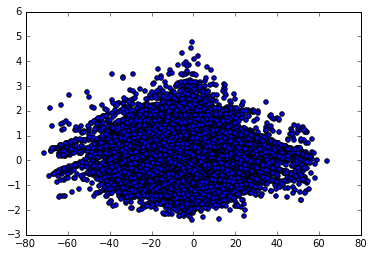

In [262]:
elev_change = df[df.Cat!='Green'].Started_at_Z.values
resid = df[df.Cat!='Green'].Shots_taken_from_location-(df[df.Cat!='Green'].Difficulty_Baseline-df[df.Cat!='Green'].Green_to_work_with_pred)
resid = resid.values
plt.scatter(elev_change,resid);

In [263]:
np.corrcoef(elev_change,resid)

array([[ 1.        , -0.02183034],
       [-0.02183034,  1.        ]])

In [264]:
X = elev_change
y = resid
X = sm.add_constant(X)
model_3 = sm.OLS(y,X)
results_3 = model_3.fit()
print results_3.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     160.2
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           1.04e-36
Time:                        18:47:34   Log-Likelihood:            -2.9120e+05
No. Observations:              335992   AIC:                         5.824e+05
Df Residuals:                  335990   BIC:                         5.824e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0031      0.001     -2.973      0.0

In [270]:
X = elev_change
X_c = pd.get_dummies(df[df.Cat!='Green'].Cat)
X_d = df[df.Cat!='Green'].Distance_from_hole.values
X = np.column_stack([X,np.multiply(X,X_d)])
X = sm.add_constant(X)
y = resid

In [271]:
pd.get_dummies(df[df.Cat!='Green'].Cat).head(1)

,Bunker,Fairway,Fringe,Intermediate Rough,Other,Primary Rough
19378,0,1,0,0,0,0


In [272]:
model_3 = sm.OLS(y,X)
results_3 = model_3.fit()
print results_3.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     80.38
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           1.25e-35
Time:                        18:51:56   Log-Likelihood:            -2.9120e+05
No. Observations:              335992   AIC:                         5.824e+05
Df Residuals:                  335989   BIC:                         5.824e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0033      0.001     -3.066      0.0

## Regress Residuals of distance with Elev. change and Green to work with

In [273]:
resid = df[df.Cat!='Green'].Shots_taken_from_location-df[df.Cat!='Green'].Difficulty_Baseline
resid = resid.values
y = resid

In [274]:
X = np.column_stack([df[df.Cat!='Green'].Green_to_work_with,df[df.Cat!='Green'].Started_at_Z])
X = sm.add_constant(X)

In [275]:
model_4 = sm.OLS(y,X)
results_4 = model_4.fit()
print results_4.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     202.2
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           1.75e-88
Time:                        18:56:28   Log-Likelihood:            -2.9121e+05
No. Observations:              335992   AIC:                         5.824e+05
Df Residuals:                  335989   BIC:                         5.824e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0262      0.002     13.281      0.0

Interpretation: with 0 green to work with, a generic shot from non-green is .0262 shots harder. Keeping elevation change constant, each additional foot of green there is to work with makes the shot .0007 strokes easier. If we keep green to work with constant, a generic non-green shot is .0015 strokes easier for each foot above the hole the shot is located.

### Try an interaction term

In [276]:
X = np.column_stack([df[df.Cat!='Green'].Green_to_work_with,
                     df[df.Cat!='Green'].Started_at_Z,
                     df[df.Cat!='Green'].Green_to_work_with*df[df.Cat!='Green'].Started_at_Z])
X = sm.add_constant(X)

In [277]:
model_4 = sm.OLS(y,X)
results_4 = model_4.fit()
print results_4.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     135.7
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           7.71e-88
Time:                        19:01:02   Log-Likelihood:            -2.9120e+05
No. Observations:              335992   AIC:                         5.824e+05
Df Residuals:                  335988   BIC:                         5.825e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0253      0.002     12.376      0.0

Not really anything there. Let's try breaking it up into catagories for the greens to work with variable.

In [280]:
X_c = pd.get_dummies(df[df.Cat!='Green'].Cat).values
X = df[df.Cat!='Green'].Green_to_work_with.values
X = sm.add_constant(X)
X = np.hstack([np.multiply(X_c,X[:,0][:,None]),np.multiply(X_c,X[:,1][:,None])])
X = np.hstack([X,df[df.Cat!='Green'].Started_at_Z.values[:,None]])

In [283]:
pd.get_dummies(df[df.Cat!='Green'].Cat).head(1)

,Bunker,Fairway,Fringe,Intermediate Rough,Other,Primary Rough
19378,0,1,0,0,0,0


In [281]:
X.shape

(335992, 13)

In [282]:
model_4 = sm.OLS(y,X)
results_4 = model_4.fit()
print results_4.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     39.70
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           2.77e-94
Time:                        19:07:07   Log-Likelihood:            -2.9117e+05
No. Observations:              335992   AIC:                         5.824e+05
Df Residuals:                  335979   BIC:                         5.825e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0342      0.005      6.213      0.0

Interpretation: Across the board it is much harder to have no green to work with. However, this is especially so for the Primary Rough, the Bunker, and the Intermediate Rough. The Fringe intercept and coefficient are the non-significant ones in the table- indicating that the amount of green to work with does not make much of a difference when on the fringe (probably since one can play a low shot such a as a putt or tiny chip).

## Train full model on lots of data and then calculate RSME improvement on test set

In [285]:
##Now need whole holes as opposed to random shots for training data
inds_chosen2 = {}
for year in range(2003,2017):
    cols = ['Course_#','Round','Hole','Permanent_Tournament_#']
    data = pd.read_csv('data/%d.csv' % (year,))
    if year==2003:
        df = data.loc[0:2,:]
    print len(data.drop_duplicates(cols))
    inds_chosen2[year] = np.random.choice(range(len(data.drop_duplicates(cols))),size=1000,replace=False)
    samp = set([tuple(i) for i in data.drop_duplicates(cols).iloc[inds_chosen2[year]][cols].values.astype(int).tolist()])
    inds = [u for u,i in enumerate(data[cols].values.astype(int).tolist()) if tuple(i) in samp]
    df = df.append(data.iloc[inds])
    if year==2003:
        df = df.drop(data.iloc[0:2].index,axis=0)
df = df.reset_index()
del data
print len(df)

2802
2997
3012
2979
2909
2912
2685
2775
2675
2597
2320
2536
2698
2422
5109678


In [ ]:
df = df[df.Shot!=1]

In [292]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [293]:
df.Cat.value_counts()

Green                 2116655
Fairway                867232
Primary Rough          402677
Bunker                 183888
Intermediate Rough     119262
Fringe                  88450
Other                   24510
Name: Cat, dtype: int64

In [294]:
##fit models
overall_models = {}
for cat in pd.unique(df.Cat):
    overall_models[cat] = IsotonicRegression(out_of_bounds='clip')
    overall_models[cat].fit(df[df.Cat==cat].Distance_from_hole,df[df.Cat==cat].Shots_taken_from_location)

In [295]:
df.insert(len(df.columns),'Difficulty_Baseline',[0]*len(df))
for cat in pd.unique(df.Cat):
    df.loc[df.Cat==cat,'Difficulty_Baseline'] = overall_models[cat].predict(df[df.Cat==cat].Distance_from_hole)

In [296]:
df.insert(len(df.columns),'Green_to_work_with',[0]*len(df))
for tup,df_ in df.groupby(['Course_#','Hole','Round']):
    green = df_[df_.Cat=='Green']
    if len(green)<5:
        continue
    non_green = df_[df_.Cat!='Green']
    df.loc[(df['Course_#']==tup[0]) 
           & (df['Hole']==tup[1]) 
           & (df['Round']==tup[2])
           & (df.Cat!='Green'), 'Green_to_work_with'] \
                = get_green_to_work_with(green,zip(non_green.Started_at_X,non_green.Started_at_Y),slack=radians(15))

In [297]:
df.insert(len(df.columns),'Slope_and_angle',[0]*len(df))

In [298]:
residuals = df[df.Cat=='Green'].Difficulty_Baseline - df[df.Cat=='Green'].Shots_taken_from_location
residuals = residuals.values
y = residuals

In [299]:
X = np.column_stack([df[df.Cat=='Green'].Started_at_Z,
                     df[df.Cat=='Green'].Distance_from_hole*df[df.Cat=='Green'].Started_at_Z])

In [300]:
X = sm.add_constant(X)

In [301]:
putting_slope_model = sm.OLS(y,X)
putting_slope_results = putting_slope_model.fit()
print putting_slope_results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 05 Sep 2016   Prob (F-statistic):          2.39e-112
Time:                        20:36:22   Log-Likelihood:            -7.1845e+05
No. Observations:             2116655   AIC:                         1.437e+06
Df Residuals:                 2116652   BIC:                         1.437e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.160      0.2

In [303]:
X_c = pd.get_dummies(df[df.Cat!='Green'].Cat).values
X = df[df.Cat!='Green'].Green_to_work_with.values
X = sm.add_constant(X)
X = np.hstack([np.multiply(X_c,X[:,0][:,None]),np.multiply(X_c,X[:,1][:,None])])
X = np.hstack([X,df[df.Cat!='Green'].Started_at_Z.values[:,None]])

In [302]:
residuals = df[df.Cat!='Green'].Difficulty_Baseline - df[df.Cat!='Green'].Shots_taken_from_location
residuals = residuals.values
y = residuals

In [304]:
non_putting_model = sm.OLS(y,X)
non_putting_results = non_putting_model.fit()
print non_putting_results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     163.6
Date:                Mon, 05 Sep 2016   Prob (F-statistic):               0.00
Time:                        20:42:03   Log-Likelihood:            -1.4592e+06
No. Observations:             1686019   AIC:                         2.918e+06
Df Residuals:                 1686006   BIC:                         2.919e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0220      0.003     -7.114      0.0

In [306]:
##RSME on test set
for year in range(2003,2017):
    cols = ['Course_#','Round','Hole','Permanent_Tournament_#']
    data = pd.read_csv('data/%d.csv' % (year,))
    if year==2003:
        df = data.loc[0:2,:]
    inds_available = list(set(range(len(data.drop_duplicates(cols)))) - set(inds_chosen2[year]))
    test_inds = np.random.choice(inds_available,size=1000,replace=False)
    samp = set([tuple(i) for i in data.drop_duplicates(cols).iloc[test_inds][cols].values.astype(int).tolist()])
    inds = [u for u,i in enumerate(data[cols].values.astype(int).tolist()) if tuple(i) in samp]
    df = df.append(data.iloc[inds])
    if year==2003:
        df = df.drop(data.iloc[0:2].index,axis=0)
df = df.reset_index()
del data
print len(df)

5122930


In [307]:
df = df[df.Shot!=1]

In [308]:
df.insert(len(df.columns),'Cat',[convert_cats(c,d) for c,d in zip(df['From_Location(Scorer)'],
                                                                  df['Distance_from_hole'])])

In [309]:
df.insert(len(df.columns),'Difficulty_Baseline',[0]*len(df))
for cat in pd.unique(df.Cat):
    df.loc[df.Cat==cat,'Difficulty_Baseline'] = overall_models[cat].predict(df[df.Cat==cat].Distance_from_hole)

In [310]:
df.insert(len(df.columns),'Green_to_work_with',[0]*len(df))
for tup,df_ in df.groupby(['Course_#','Hole','Round']):
    green = df_[df_.Cat=='Green']
    if len(green)<5:
        continue
    non_green = df_[df_.Cat!='Green']
    df.loc[(df['Course_#']==tup[0]) 
           & (df['Hole']==tup[1]) 
           & (df['Round']==tup[2])
           & (df.Cat!='Green'), 'Green_to_work_with'] \
                = get_green_to_work_with(green,zip(non_green.Started_at_X,non_green.Started_at_Y),slack=radians(15))

In [311]:
df.insert(len(df.columns),'Resid_prediction',[0]*len(df))

In [313]:
X = np.column_stack([df[df.Cat=='Green'].Started_at_Z,
                     df[df.Cat=='Green'].Distance_from_hole*df[df.Cat=='Green'].Started_at_Z])
X = sm.add_constant(X)

In [314]:
df.loc[df.Cat=='Green','Resid_prediction'] = putting_slope_results.predict(X)

In [320]:
X_c = pd.get_dummies(df[df.Cat!='Green'].Cat).values
X = df[df.Cat!='Green'].Green_to_work_with.values
X = sm.add_constant(X)
X = np.hstack([np.multiply(X_c,X[:,0][:,None]),np.multiply(X_c,X[:,1][:,None])])
X = np.hstack([X,df[df.Cat!='Green'].Started_at_Z.values[:,None]])

In [321]:
df.loc[df.Cat!='Green','Resid_prediction'] = non_putting_results.predict(X)

count    1686710.000000
mean           0.000629
std            0.019876
min           -0.137986
25%           -0.008385
50%            0.000826
75%            0.009766
max            0.182941
Name: Resid_prediction, dtype: float64


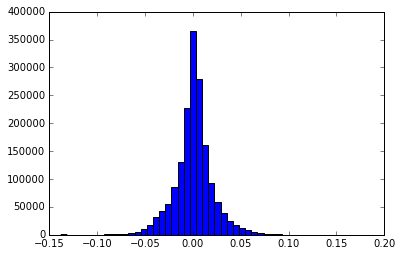

In [326]:
print df[df.Cat!='Green'].Resid_prediction.describe()
plt.hist(df[df.Cat!='Green'].Resid_prediction.values,50);

In [328]:
for cat in pd.unique(df.Cat):
    RSME_baseline = np.mean((df[df.Cat==cat].Shots_taken_from_location - 
                             df[df.Cat==cat].Difficulty_Baseline)**2)**.5
    RSME_plus = np.mean((df[df.Cat==cat].Shots_taken_from_location - 
         (df[df.Cat==cat].Difficulty_Baseline - df[df.Cat==cat].Resid_prediction))**2)**.5
    improvement = (RSME_baseline - RSME_plus)/RSME_baseline
    print cat, RSME_baseline, RSME_plus,improvement

Intermediate Rough 0.549767405276 0.549607501093 0.000290857881902
Green 0.339635079764 0.339585105841 0.000147140051134
Primary Rough 0.603420289482 0.602779579875 0.00106179659192
Fairway 0.563065912981 0.562960572797 0.00018708322101
Bunker 0.610542320215 0.61018236541 0.000589565691608
Fringe 0.427261159131 0.427223735941 8.75885602657e-05
Other 0.710707903337 0.710554704315 0.00021555834789


In [345]:
df[['Shots_taken_from_location','Difficulty_Baseline','Cat','Resid_prediction','Started_at_Z','Green_to_work_with']].head(30)

,Shots_taken_from_location,Difficulty_Baseline,Cat,Resid_prediction,Started_at_Z,Green_to_work_with
97106,3,3.088193,Intermediate Rough,0.022772,2.293,76.847099
97107,2,1.901782,Green,0.017898,-0.898,0.000000
97108,2,3.215818,Primary Rough,0.000791,-4.966,51.760889
97109,2,2.044434,Green,0.012433,-1.395,0.000000
97110,3,3.026131,Fairway,-0.002442,-6.055,58.475965
97111,3,2.922397,Fairway,-0.006577,-9.334,63.372360
97112,3,3.081544,Fairway,0.004311,-5.055,78.192199
97113,2,2.509823,Bunker,-0.010631,-1.703,22.382596
97114,3,2.955528,Fairway,0.004112,-3.175,65.460941
97115,3,2.835379,Fairway,0.032431,19.596,29.918603


In [344]:
(((df.Difficulty_Baseline-df.Resid_prediction)-df.Shots_taken_from_location)**2 <\
(df.Difficulty_Baseline-df.Shots_taken_from_location)**2).sum()/float(len(df))

0.4842092034577245